# Correlate charcoal contamination estimate against GUNC contamination estimate

In [1]:
setwd("..")

In [19]:
library(dplyr)
library(readr)
library(tidyr)
library(ggplot2)
library(ggpubr)
source("~/github/2022-microberna/scripts/utils.R")

## Read in contamination results

In [15]:
gtdb_metadata <- read_tsv("inputs/gtdb/bac120_metadata_r202.tsv", show_col_types = F) %>%
  separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
           sep = ";") %>%
  mutate(ncbi_database = ifelse(grepl(pattern = "GB", accession), "GenBank", "none"),
         ncbi_database = ifelse(grepl(pattern = "RS", accession), "RefSeq", ncbi_database)) %>%
  mutate(accession = gsub("GB_", "", accession)) %>%
  mutate(accession = gsub("RS_", "", accession))

gtdb_metadata <- read_tsv("inputs/gtdb/ar122_metadata_r202.tsv", show_col_types = F) %>%
  separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
           sep = ";") %>%
  mutate(ncbi_database = ifelse(grepl(pattern = "GB", accession), "GenBank", "none"),
         ncbi_database = ifelse(grepl(pattern = "RS", accession), "RefSeq", ncbi_database)) %>%
  mutate(accession = gsub("GB_", "", accession)) %>%
  mutate(accession = gsub("RS_", "", accession)) %>%
  bind_rows(gtdb_metadata)

gtdb_metadata <- gtdb_metadata %>%
  mutate(order_lineage = paste(sep = ";", domain, phylum, class, order))

Warning message:
“One or more parsing issues, see `problems()` for details”


In [46]:
charcoal <- read_csv("outputs/gtdb_rs202_charcoal1/stage1_hitlist.csv", show_col_types = F)%>%
  mutate(genome = gsub("_genomic.fna.gz", "", genome))

combined <- left_join(charcoal, gtdb_metadata, by = c("genome" = "accession")) %>%
  mutate(lineages_match = ifelse(lineage == order_lineage, T, F),
         charcoal_contamination_order = (order_bad_bp/genome_size)*100,
         charcoal_contamination_family = (family_bad_bp/genome_size)*100,
         charcoal_contamination_genus = (genus_bad_bp/genome_size)*100,
         contaminated_at_superkingdom = ifelse(superkingdom_bad_bp > 0, T, F),
         contaminated_at_phylum = ifelse(phylum_bad_bp > 0, T, F),
         contaminated_at_class = ifelse(class_bad_bp > 0, T, F),
         contaminated_at_order = ifelse(order_bad_bp > 0, T, F),
         contaminated_at_family = ifelse(family_bad_bp > 0, T, F),
         contaminated_at_genus = ifelse(genus_bad_bp > 0, T, F))


In [57]:
head(charcoal)

genome,filter_at,override_filter_at,total_bad_bp,superkingdom_bad_bp,phylum_bad_bp,class_bad_bp,order_bad_bp,family_bad_bp,genus_bad_bp,f_ident,f_major,lineage,comment
<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GCF_001870225.1,order,NA,3049282,0,0,0,3049282,3049282,3049282,0.600,0.002,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Gloeomargaritales,NA
GCA_012103325.1,order,NA,1704793,0,0,0,1704793,2772302,2772302,0.446,0.014,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__UBA8366,NA
GCF_003318295.1,order,NA,932028,0,0,0,932028,932028,932028,0.515,0.014,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales_G,NA
GCA_001897525.1,order,NA,930915,0,0,0,930915,2788654,2788654,0.451,0.054,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales,NA
GCA_900762445.1,order,NA,806201,0,806201,806201,806201,1137819,1137819,0.629,0.029,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales,NA
GCF_900101835.1,order,NA,558474,0,558474,558474,558474,558474,558474,0.457,0.018,d__Bacteria;p__Firmicutes_B;c__Peptococcia;o__Peptococcales,NA


In [56]:
head(combined$genome_size)

[1] 6333795 4727320 2160199 2654226 4431252 1313578

## Check checkm contam 

In [63]:
combined <- combined %>%
  mutate(checkm_contamination_logical = ifelse(checkm_contamination > 0, "TRUE_checkm", "FALSE_checkm"))

print("superkingdom")
table(combined$checkm_contamination_logical, combined$contaminated_at_superkingdom)
print("phylum")
table(combined$checkm_contamination_logical, combined$contaminated_at_phylum)
print("class")
table(combined$checkm_contamination_logical, combined$contaminated_at_class)
print("order")
table(combined$checkm_contamination_logical, combined$contaminated_at_order)
print("family")
table(combined$checkm_contamination_logical, combined$contaminated_at_family)
print("genus")
table(combined$checkm_contamination_logical, combined$contaminated_at_genus)


[1] "superkingdom"


              
               FALSE TRUE
  FALSE_checkm   611    3
  TRUE_checkm   2106   45

[1] "phylum"


              
               FALSE TRUE
  FALSE_checkm   559   55
  TRUE_checkm   1712  439

[1] "class"


              
               FALSE TRUE
  FALSE_checkm   545   69
  TRUE_checkm   1638  513

[1] "order"


              
               FALSE TRUE
  FALSE_checkm   525   89
  TRUE_checkm   1518  633

[1] "family"


              
               FALSE TRUE
  FALSE_checkm   100  514
  TRUE_checkm    230 1921

[1] "genus"


              
               FALSE TRUE
  FALSE_checkm   100  514
  TRUE_checkm    230 1921

## Check against GUNC contam

In [9]:
gunc <- read_tsv("~/Downloads/charcoal_papers/All_Datasets.GUNC.scores.maxCSS_level.tsv", show_col_types = F) %>%
  filter(study == "GenBank")

In [27]:
head(gunc, n = 20)

genome,n_genes_called,n_genes_mapped,n_contigs,taxonomic_level,proportion_genes_retained_in_major_clades,genes_retained_index,clade_separation_score,contamination_portion,n_effective_surplus_clades,mean_hit_identity,reference_representation_score,pass.GUNC,study,CheckM_completeness,CheckM_contamination
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>
GCA_902163475.1,2754,2671,20,kingdom,1.00,0.97,0.00,0.00,0.00,0.95,0.92,TRUE,GenBank,NaN,NaN
GCA_902506205.1,3149,3072,1,kingdom,1.00,0.98,0.00,0.00,0.00,0.86,0.84,TRUE,GenBank,NaN,NaN
GCA_903881675.1,4607,4401,142,class,0.93,0.89,0.09,0.10,0.22,0.65,0.58,TRUE,GenBank,NaN,NaN
GCA_902535955.1,1892,1753,83,class,0.92,0.85,0.09,0.26,0.75,0.55,0.47,TRUE,GenBank,NaN,NaN
GCA_902586975.1,1016,888,75,genus,0.63,0.55,0.26,0.28,0.80,0.67,0.37,TRUE,GenBank,NaN,NaN
GCA_902589975.1,109,107,12,genus,0.99,0.97,0.08,0.30,0.73,0.73,0.71,TRUE,GenBank,NaN,NaN
GCA_902596985.1,1880,1754,94,family,0.74,0.69,0.21,0.23,0.57,0.58,0.40,TRUE,GenBank,NaN,NaN
GCA_902598415.1,616,608,51,genus,0.96,0.95,0.10,0.03,0.06,0.93,0.88,TRUE,GenBank,NaN,NaN
GCA_902619715.1,1221,1214,61,kingdom,1.00,0.99,0.00,0.00,0.00,0.98,0.97,TRUE,GenBank,NaN,NaN


In [17]:
table(combined$genome %in% gunc$genome)


FALSE  TRUE 
10156  2765 

In [50]:
combined <- left_join(combined, gunc, by = "genome") %>%
  filter(!is.na(contamination_portion))

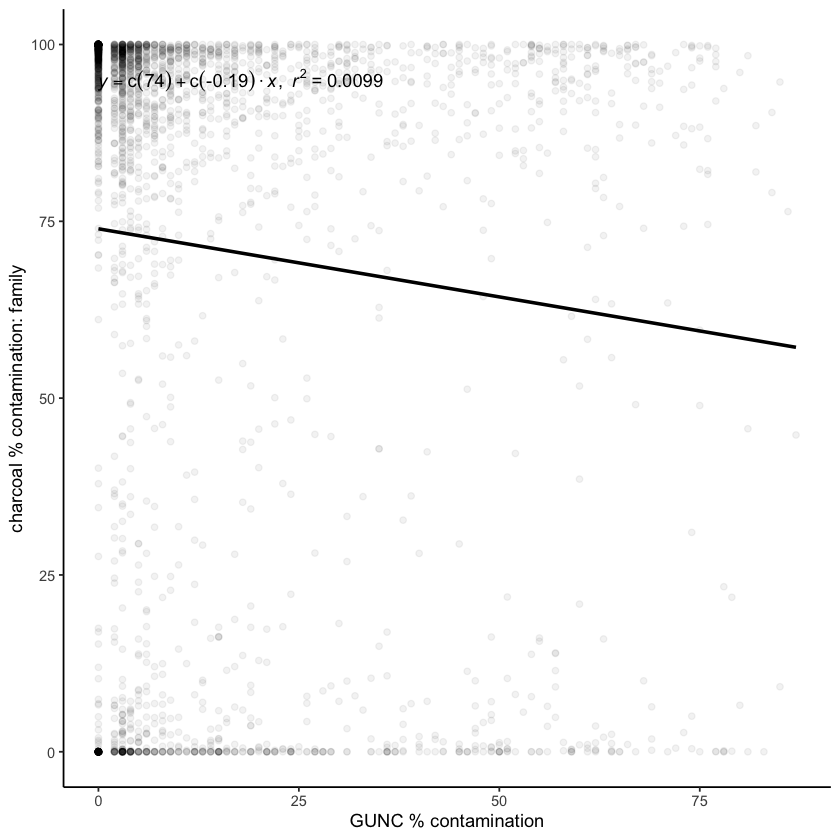

In [54]:
ggplot(combined, aes(x = (contamination_portion)*100, y = charcoal_contamination_order)) +
  geom_point(alpha = 0.05) +
  theme_classic() +
  labs(x = "GUNC % contamination", y = "charcoal % contamination: order") +
  #scale_y_log10() +
  #scale_x_log10() +
  stat_smooth_func(geom = 'text', method = 'lm', hjust = 0, parse = T) +
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x)

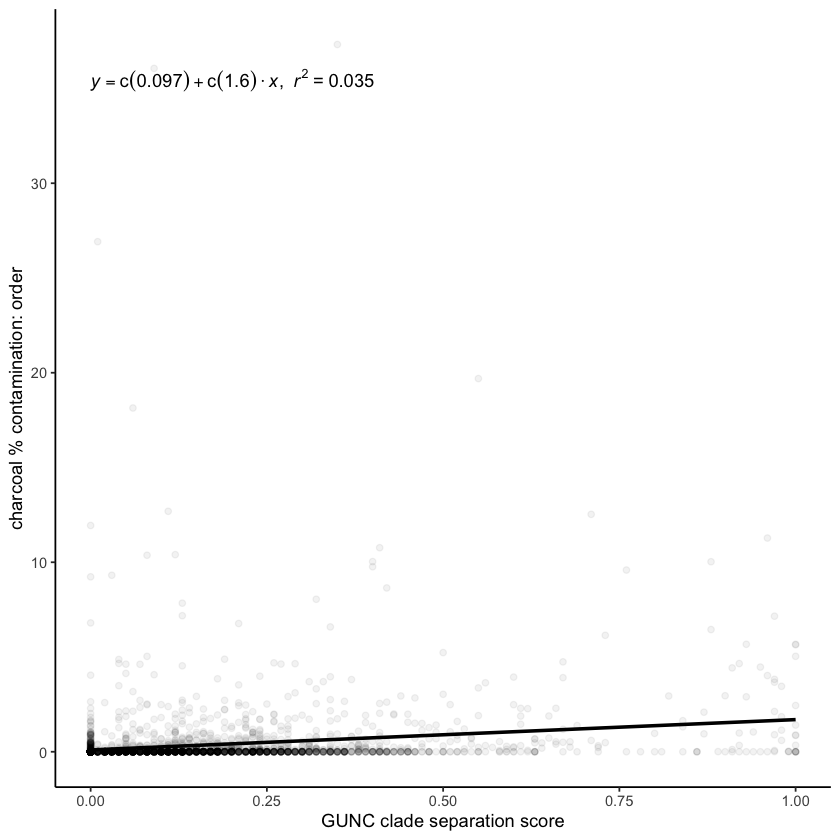

In [53]:
ggplot(combined, aes(x = clade_separation_score, y = charcoal_contamination_order)) +
  geom_point(alpha = 0.05) +
  theme_classic() +
  labs(x = "GUNC clade separation score", y = "charcoal % contamination: order") +
  #scale_y_log10() +
  #scale_x_log10() +
  stat_smooth_func(geom = 'text', method = 'lm', hjust = 0, parse = T) +
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x)

In [59]:
table(combined$pass.GUNC)


FALSE  TRUE 
  185  2580 

In [58]:
combined <- combined %>%
  mutate(GUNC_contaminated = ifelse(pass.GUNC == TRUE, "FALSE_gunc", "TRUE_gunc"))

print("superkingdom")
table(combined$GUNC_contaminated, combined$contaminated_at_superkingdom)
print("phylum")
table(combined$GUNC_contaminated, combined$contaminated_at_phylum)
print("class")
table(combined$GUNC_contaminated, combined$contaminated_at_class)
print("order")
table(combined$GUNC_contaminated, combined$contaminated_at_order)
print("family")
table(combined$GUNC_contaminated, combined$contaminated_at_family)
print("genus")
table(combined$GUNC_contaminated, combined$contaminated_at_genus)

[1] "superkingdom"


            
             FALSE TRUE
  FALSE_gunc  2542   38
  TRUE_gunc    175   10

[1] "phylum"


            
             FALSE TRUE
  FALSE_gunc  2175  405
  TRUE_gunc     96   89

[1] "class"


            
             FALSE TRUE
  FALSE_gunc  2097  483
  TRUE_gunc     86   99

[1] "order"


            
             FALSE TRUE
  FALSE_gunc  1974  606
  TRUE_gunc     69  116

[1] "family"


            
             FALSE TRUE
  FALSE_gunc   321 2259
  TRUE_gunc      9  176

[1] "genus"


            
             FALSE TRUE
  FALSE_gunc   321 2259
  TRUE_gunc      9  176

In [45]:
colnames(charcoal)

[1] "genome"              "filter_at"           "override_filter_at" 
 [4] "total_bad_bp"        "superkingdom_bad_bp" "phylum_bad_bp"      
 [7] "class_bad_bp"        "order_bad_bp"        "family_bad_bp"      
[10] "genus_bad_bp"        "f_ident"             "f_major"            
[13] "lineage"             "comment"

## Summary

The correlations between proportion/percent of contamination between different methods are quite poor, but we have non-horrible overlap between the genomes that are detected to be contaminated by one method and another.
On one extreme, charcoal underestimates contamination compared with checkM, with checkM finding ~1500 more genomes contaminated than charcoal does at the order level. 
On the other end, GUNC and charcoal find 116 of the same genomes to be contaminated, while GUNC finds 69 that charcoal misses and charcoal finds 606 that GUNC misses.